# Shanice's version from Ryan's SOSE code

# SOSE Heat Budget

Evaluating the conservation of heat content in the Southern Ocean State Estimate 

Author: [Shanice Bailey](https://github.com/stb2145)

![SOSE Logo](http://sose.ucsd.edu/images/SOSEpic.png)

In [61]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

## Open SOSE Dataset from Gyre

In [62]:
from dask.distributed import Client, LocalCluster, progress
cluster = LocalCluster(n_workers=4, threads_per_worker=8, ip='*')
client = Client(cluster)
client

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://129.236.21.48:45913 Dashboard: http://129.236.21.48:35381/status,Cluster Workers: 4 Cores: 32 Memory: 480.84 GB


In [63]:
ds = xr.open_zarr('/swot/SUM03/tmp/SOSE')
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

Optimization trick from Ryan's NB: split ds into coords and data variables then drop coordinates from data variables.

In [64]:
coords = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

In [65]:
coords

<xarray.Dataset>
Dimensions:  (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zu       (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * XG       (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * Zp1      (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
Data variables:
    dyG      (YC, XG) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefF   (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
    dxG      (YG, XC) flo

## Create XGCM Grid

In [66]:
import xgcm
grid = xgcm.Grid(ds, periodic=('XC', 'YC'))
grid

<xgcm.Grid>
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
T Axis (not periodic):
  * center   time
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (not periodic):
  * center   XC --> left
  * left     XG --> center

## Tracer Budgets

Here we will do the heat budget for SOSE. In integral form, this budget can be written as

$$
\mathcal{V} \frac{\partial \theta}{\partial t} = G^\theta_{adv} + G^\theta_{diff} + G^\theta_{surf} + G^\theta_{linfs} + G^\theta_{sw}
$$

where $\mathcal{V}$ is the volume of the grid cell. The terms on the right-hand side are called _tendencies_. They add up to the total tendency (the left hand side).

The first term is the convergence of advective fluxes. The second is the convergence of diffusive fluxes. The third is the explicit surface flux. The fourth is the correction due to the linear free-surface approximation. The fifth is shortwave penetration (only for temperature).

### Flux Divergence

First we define a function to calculate the convergence of the advective and diffusive fluxes, since this has to be eventually repeated for both tracers.

## Heat component of buoyancy budget integrated over Weddell Sea Region
Here, $\mathcal{V}$, represents the closed system of the Weddell Sea.

$$
\int_{R}{\frac{\partial{\theta}}{\partial{t}}}d\mathcal{V} = -\int_{NB}F^{\theta}_{adv,y}dA - \int_{NB} F^{\theta}_{diff,y}dA - \int_{surf}F^{\theta}_{surf}\vert_{z=0}dA
$$

where 'NB' denotes northern boundary of region R; 'surf' represents the boundary closed by the ocean surface; and $F^{\theta}_{surf}$ term includes the above $G^{\theta}_{surf}$ and $G^{\theta}_{sw}$. Both the first term and second term represents the the northern boundary crossing of the meridional advective flux and meridional diffusive flux, respectively; and the last term represents the surface flux crossing the ocean surface area.

Left-hand side can be written as: $\mathcal{V}\frac{\partial{\theta}}{\partial{t}}$ since $V = \int_{R}\mathcal{H}(\tilde{\theta} - \theta)\ dV$

In [67]:
coords.rAs

<xarray.DataArray 'rAs' (YG: 320, XC: 2160)>
dask.array<shape=(320, 2160), dtype=float32, chunksize=(320, 2160)>
Coordinates:
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
Attributes:
    long_name:      cell area
    standard_name:  cell_area_at_v_location
    units:          m2

In [68]:
#adv flux terms already take into acct cell area (look at the units)
dsr.ADVy_TH

<xarray.DataArray 'ADVy_TH' (time: 438, Z: 42, YG: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Meridional Advective Flux of Pot.Temperature
    mate:           ADVx_TH
    standard_name:  ADVy_TH
    units:          degC.m^3/s

In [137]:
dsr.TFLUX

<xarray.DataArray 'TFLUX' (time: 438, YC: 320, XC: 2160)>
dask.array<shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      total heat flux (match heat-content variations), >0 incre...
    standard_name:  TFLUX
    units:          W/m^2

In [138]:
first_term = dsr.ADVy_TH.sel(YG=-60, method='nearest') + dsr.ADVx_TH.sel(XG=0, method='nearest')
second_term = dsr.DFyE_TH.sel(YG=-60, method='nearest') + dsr.DFxE_TH.sel(XG=-60, method='nearest')
third_term = dsr.TFLUX.sel(XC=slice(290,360), YC=slice(-80,-60))

In [139]:
first_term

<xarray.DataArray (time: 438, Z: 42, XC: 2160, YC: 320)>
dask.array<shape=(438, 42, 2160, 320), dtype=float32, chunksize=(1, 42, 2160, 320)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YG       float32 -59.9583
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG       float32 5.551115e-17
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083

In [73]:
import timeit

In [76]:
#zooming in to WG region
#Longitude is closed boundary
#Latitude is not closed boundary
%timeit test = first_term.sel(XC=slice(290, 360), YC=slice(-80, -60)).sum(dim=('XC', 'YC', 'Z')).load()

1min 37s ± 12.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
test = first_term.sel(XC=slice(290, 360), YC=slice(-80, -60)).sum(dim=('XC', 'YC', 'Z')).load()
test

In [ ]:
test.plot(figsize=(12,6))
plt.xlim('2005', '2011')
plt.grid();

In [ ]:
heat_budget = - first_term - second_term - third_term
heat_budget

In [ ]:
%timeit heat_budget_weddell = heat_budget.sel(XC=slice(290,360), YC=slice(-80,-60)).sum(dim=('XC', 'YC', 'Z')).load()

In [ ]:
heat_budget_weddell = heat_budget.sel(XC=slice(290,360), YC=slice(-80,-60)).sum(dim=('XC', 'YC', 'Z')).load()
heat_budget_weddell

In [ ]:
heat_budget_weddell.plot(figsize=(12,6))
plt.grid()
plt.xlim('2005', '2011')
plt.ylim(heat_budget_weddell.min(), heat_budget_weddell.max());

In [ ]:
heat_budget_weddell_mm = heat_budget_weddell.groupby('time.month').mean(dim='time')
heat_budget_weddell_anom = heat_budget_weddell.groupby('time.month') - heat_budget_weddell_mm
heat_budget_weddell_anom

In [ ]:
#why rolling 30?
heat_budget_weddell_anom.rolling(time=30).mean().plot(figsize=(12,6))
plt.grid()
plt.xlim('2005', '2011')
plt.axhline(y=0, color='k')
plt.title('Weddell Sea Heat Budget Anomaly')
plt.ylabel(r'˚C $\frac{m^3}{s}$');

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [77]:
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

# Heat budget for Weddell Gyre

In [140]:
#set the boundaries
lat_range = dict(YC=slice(-80, -60))
lon_range = dict(XC=slice(290, 360))

In [295]:
sst_mean = dsr.THETA.isel(Z=0).mean(dim='time').load()

In [307]:
surface_mask = (coords.hFacC[0]>0).load()

(-80, -55)

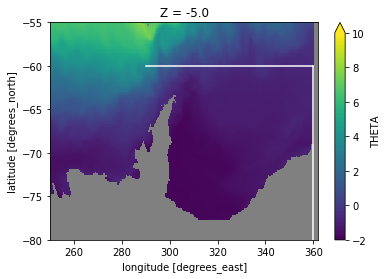

In [313]:
fig, ax = plt.subplots(subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([290, 360], [-60, -60], color='w')
ax.plot([360, 360], [-80, -60], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
ax.set_xlim([250, 362])
ax.set_ylim([-80, -55])

In [235]:
#advective flux
adv_flux_y = dsr.ADVy_TH.sel(**lon_range).sel(YG=-60, method='nearest').sum(dim=['XC', 'Z']).load()
adv_flux_x = dsr.ADVx_TH.sel(**lat_range).sel(XG=360, method='nearest').sum(dim=['YC', 'Z']).load()
adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([3.123971e+07, 1.005984e+08, 1.139938e+08, ..., 1.220148e+08,
       1.094228e+08, 1.161756e+08], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -59.9583

In [266]:
yg_index = dsr.indexes['YG']
yg_index.get_loc(-60, method='nearest')

108

In [237]:
adv_flux_y

<xarray.DataArray 'ADVy_TH' (time: 438)>
array([3.461427e+07, 1.041845e+08, 1.117970e+08, ..., 1.225256e+08,
       1.101034e+08, 1.169300e+08], dtype=float32)
Coordinates:
    YG       float32 -59.9583
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [255]:
#diffusive flux
diff_flux_y = dsr.DFyE_TH.sel(**lon_range).sel(YG=-60, method='nearest').sum(dim=['XC', 'Z']).load()
diff_flux_x = dsr.DFxE_TH.sel(**lat_range).sel(XG=360, method='nearest').sum(dim=['YC', 'Z']).load()
diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-182697.66 ,  -22155.754,  -65134.64 , ...,  107408.586,  128722.08 ,
         87199.94 ], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -59.9583

In [221]:
#vertical flux
t_flux_z = (dsr.TFLUX.sel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([2.183112e+14, 2.600259e+14, 2.185133e+14, ..., 3.302395e+14,
       3.279043e+14, 3.643701e+14], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [222]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                     ).sel(YC=slice(-80, -60)).sum(dim=['XC', 'YC'])
#units: (˚C m^3)/s

In [223]:
surface_term.load()
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([34009980.  ,  -501511.62, -4915518.  , ...,  2207332.5 , -5533959.5 ,
        3560072.5 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

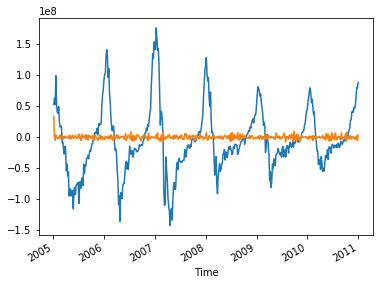

In [224]:
surface_term.plot()
lin_fs_correction.plot()

In [225]:
#is it hFacC or hFacS
total_volume = (coords.rA + coords.drF + coords.hFacC).sum().load()
total_volume

<xarray.DataArray ()>
array(6.010579e+15, dtype=float32)

In [227]:
tottend_weddell = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC
          ).sel(**lon_range, **lat_range).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tottend_weddell.load()
#units: (˚C m^3)/s
#left hand side

<xarray.DataArray (time: 438)>
array([65429595.022222, 70549249.137778, 57274440.817778, ..., 77866847.194074,
       76623975.158519, 91236913.303704])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

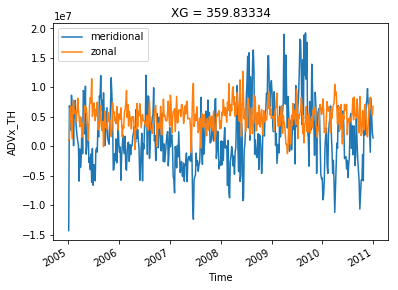

In [256]:
adv_flux_y.plot(label='meridional')
adv_flux_x.plot(label='zonal')
plt.legend();

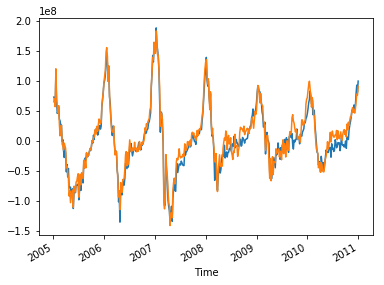

In [274]:
rhs = + adv_flux + diff_flux +  lin_fs_correction + surface_term
lhs = tottend_weddell
rhs.plot()
lhs.plot()

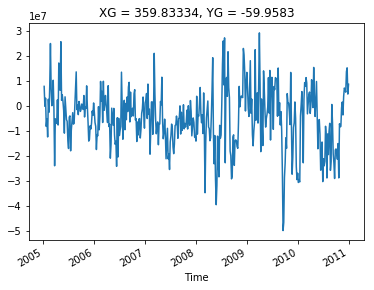

In [292]:
(rhs - lhs).plot()

In [293]:
(rhs - lhs).mean()

<xarray.DataArray ()>
array(-4782131.051607)
Coordinates:
    XG       float32 359.83334
    YG       float32 -59.9583

In [278]:
tottend_weddell.rename('shanice')

<xarray.DataArray 'shanice' (time: 438)>
array([65429595.022222, 70549249.137778, 57274440.817778, ..., 77866847.194074,
       76623975.158519, 91236913.303704])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [280]:
all_terms = xr.merge([tottend_weddell.rename('tottend'),
                      adv_flux.rename('adv_flux'),
                      diff_flux.rename('diff_flux'),
                      lin_fs_correction.rename('lin_fs'),
                      surface_term.rename('surface')])
all_terms

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG         float32 359.83334
    YG         float32 -59.9583
Data variables:
    tottend    (time) float64 6.543e+07 7.055e+07 ... 7.662e+07 9.124e+07
    adv_flux   (time) float32 -13310190.0 8101754.0 ... 7511841.0 8177555.5
    diff_flux  (time) float32 -182697.66 -22155.754 ... 128722.08 87199.94
    lin_fs     (time) float32 34009980.0 -501511.62 ... -5533959.5 3560072.5
    surface    (time) float32 52811384.0 62902550.0 ... 79322920.0 88144310.0

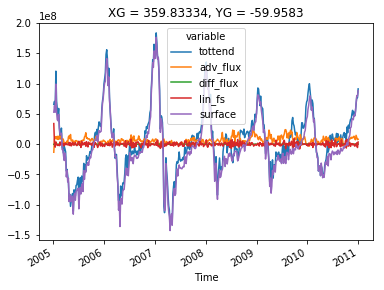

In [316]:
all_terms.to_array().plot.line(x='time')

In [288]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

,budget
variable,
tottend,5.807157e+06
adv_flux,6.684837e+06
diff_flux,-4.509156e+03
lin_fs,8.794732e+03
surface,-5.664096e+06


In [291]:
df.iloc[1:].sum()

budget    1.025026e+06
dtype: float64

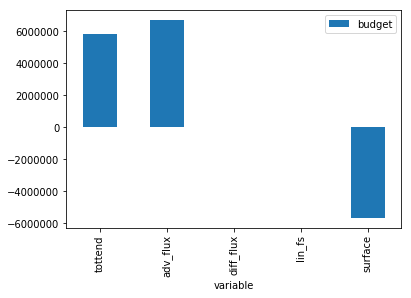

In [289]:
df.plot(kind='bar')

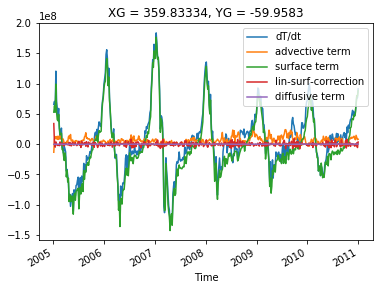

In [317]:
tottend_weddell.plot(label='dT/dt')
adv_flux.plot(label='advective term')
surface_term.plot(label='surface term')
lin_fs_correction.plot(label='lin-surf-correction')
diff_flux.plot(label='diffusive term')
plt.legend();

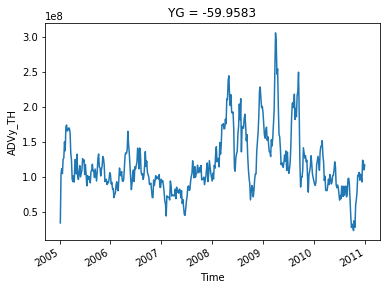

In [240]:
adv_flux_y.plot()

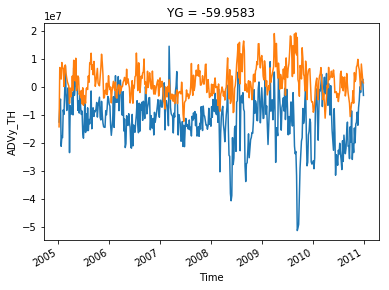

In [262]:
(surface_term - tottend_weddell).plot()
adv_flux_y.plot(label='adv flux y')

In [242]:
test = surface_term - tottend_weddell
test

<xarray.DataArray (time: 438)>
array([-12618211.022222,  -7646697.137778,  -4414148.817778, ...,
         2020984.805926,   2698944.841481,  -3092601.303704])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [231]:
dsr.TOTTTEND

<xarray.DataArray 'TOTTTEND' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Tendency of Potential Temperature
    standard_name:  TOTTTEND
    units:          degC/day

# Heat Budget for Lower Cell of WG

In [252]:
#set the boundaries
lat_range = dict(YC=slice(-80, -60))
lon_range = dict(XC=slice(290, 360))
lower_cell_range = dict(Z=slice(-2e03, -5.575e03))

In [253]:
#advective flux
adv_flux_y = dsr.ADVy_TH.sel(**lon_range, **lower_cell_range).sel(YG=-60, method='nearest'
                                                                 ).sum(dim=['XC', 'Z']).load()
adv_flux_x = dsr.ADVx_TH.sel(**lat_range, **lower_cell_range).sel(XG=360, method='nearest'
                                                                 ).sum(dim=['YC', 'Z']).load()
adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-13310190. ,   8101754. ,  12560044. , ...,  10995880. ,   7511841. ,
         8177555.5], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -59.9583

In [254]:
#diffusive flux
diff_flux_y = dsr.DFyE_TH.sel(**lon_range, **lower_cell_range).sel(YG=-60, method='nearest'
                                                                  ).sum(dim=['XC', 'Z']).load()
diff_flux_x = dsr.DFxE_TH.sel(**lat_range, **lower_cell_range).sel(XG=360, method='nearest'
                                                                  ).sum(dim=['YC', 'Z']).load()
diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-24170.133 ,   5649.919 , -30633.68  , ...,  16922.201 ,  11428.421 ,
         7512.0264], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -59.9583

In [221]:
#vertical flux
#slice for z for this term?
t_flux_z = (dsr.TFLUX.sel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([2.183112e+14, 2.600259e+14, 2.185133e+14, ..., 3.302395e+14,
       3.279043e+14, 3.643701e+14], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [222]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                     ).sel(YC=slice(-80, -60)).sum(dim=['XC', 'YC'])
#units: (˚C m^3)/s

In [223]:
surface_term.load()
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([34009980.  ,  -501511.62, -4915518.  , ...,  2207332.5 , -5533959.5 ,
        3560072.5 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

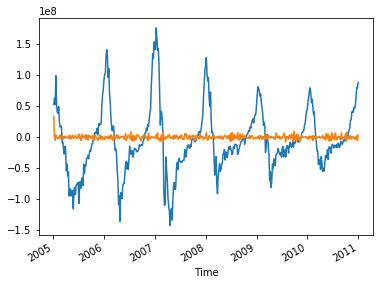

In [224]:
surface_term.plot()
lin_fs_correction.plot()

In [225]:
#is it hFacC or hFacS
total_volume = (coords.rA + coords.drF + coords.hFacC).sum().load()
total_volume

<xarray.DataArray ()>
array(6.010579e+15, dtype=float32)

In [226]:
dsr.TOTTTEND

<xarray.DataArray 'TOTTTEND' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Tendency of Potential Temperature
    standard_name:  TOTTTEND
    units:          degC/day

In [227]:
tottend_weddell = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC
          ).sel(**lon_range, **lat_range).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tottend_weddell.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([65429595.022222, 70549249.137778, 57274440.817778, ..., 77866847.194074,
       76623975.158519, 91236913.303704])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

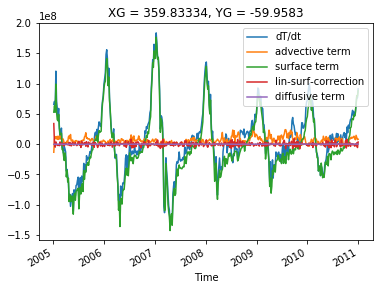

In [257]:
tottend_weddell.plot(label='dT/dt')
adv_flux.plot(label='advective term')
surface_term.plot(label='surface term')
lin_fs_correction.plot(label='lin-surf-correction')
diff_flux.plot(label='diffusive term')
plt.legend();

In [ ]:
adv_flux_y.plot()

In [ ]:
(surface_term - tottend_weddell).plot()
adv_flux_y.plot(label='adv flux y')

# Heat budget for full SO south of 55S

Weddell sea will be more complicate but similar.

We need to calculate
- the merional advective and diffusive fluxes across 55S.
- the surface fluxes for the whole region south of 55S.
- the total time rate of change of the temperature in this region.

In [86]:
# advective flux
flux_across_55S = dsr.ADVy_TH.sel(YG=-55, method='nearest').sum(dim=['XC', 'Z'])
flux_across_55S

<xarray.DataArray 'ADVy_TH' (time: 438)>
dask.array<shape=(438,), dtype=float32, chunksize=(1,)>
Coordinates:
    YG       float32 -54.958298
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [98]:
# diffusive flux
diff_flux_across_55s = dsr.DFyE_TH.sel(YG=-55, method='nearest').sum(dim=['XC', 'Z']).load()

In [ ]:
# surface flux

In [80]:
dsr.TFLUX.dims

('time', 'YC', 'XC')

In [88]:
dsr.TFLUX.units

'W/m^2'

In [87]:
tflux_south_of_55S = (dsr.TFLUX.sel(YC=slice(-90, -55)) * coords.rA).sum(dim=['XC', 'YC'])
tflux_south_of_55S

<xarray.DataArray (time: 438)>
dask.array<shape=(438,), dtype=float32, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [89]:
heat_capacity_cp = 3.994e3
runit2mass = 1.035e3
surface_term = tflux_south_of_55S / (heat_capacity_cp * runit2mass)

In [100]:
lin_fs_correction_th = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                          ).sel(YC=slice(-90, -55)).sum(dim=['XC', 'YC'])

In [102]:
lin_fs_correction_th.load()

<xarray.DataArray (time: 438)>
array([ 87602840.  ,  -4577356.  ,  -8794170.  , ...,   -715020.94,
       -10347342.  ,   8000417.  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [94]:
%time surface_term.load()

CPU times: user 3.73 s, sys: 591 ms, total: 4.32 s
Wall time: 5.23 s


<xarray.DataArray (time: 438)>
array([2.934940e+08, 4.076752e+08, 2.458431e+08, ..., 7.492168e+08,
       7.764266e+08, 8.050719e+08], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

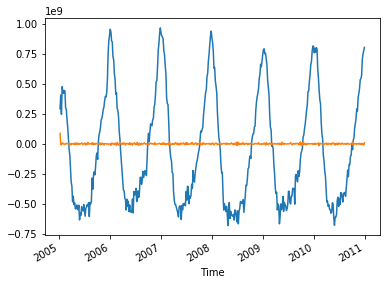

In [103]:
surface_term.plot()
lin_fs_correction_th.plot()

In [96]:
%time flux_across_55S.load()

CPU times: user 4.96 s, sys: 996 ms, total: 5.96 s
Wall time: 8.49 s


<xarray.DataArray 'ADVy_TH' (time: 438)>
array([-4.733794e+07, -1.096863e+08, -7.422400e+07, ..., -4.946936e+07,
       -1.168052e+06, -5.848695e+06], dtype=float32)
Coordinates:
    YG       float32 -54.958298
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [128]:
total_volume = (coords.rA * coords.drF * coords.hFacC).sum().load()
total_volume

<xarray.DataArray ()>
array(4.783496e+17, dtype=float32)

In [129]:
tottend_south_of_55s.mean() / total_volume
# units: degrees per day

<xarray.DataArray ()>
array(1.699909e-06, dtype=float32)

In [125]:
# net annual mean warming rate south of 55S for the whole SOSE period
(tottend_south_of_55s / (24*60*60)).mean() / 1e6
# units are 10^6 deg m^3 / s

<xarray.DataArray ()>
array(9.411468)

In [126]:
# rate that advection is working to change the temperature 
(-flux_across_55S).mean() / 1e6
# positive means advection is bringing in net heat

<xarray.DataArray 'ADVy_TH' ()>
array(62.794716)
Coordinates:
    YG       float32 -54.958298

In [127]:
# rate of surface heating / cooling
surface_term.mean() / 1e6
# negative means net cooling at the surface

<xarray.DataArray ()>
array(-53.570144)

In [107]:
# total tendency
dsr.TOTTTEND

<xarray.DataArray 'TOTTTEND' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Tendency of Potential Temperature
    standard_name:  TOTTTEND
    units:          degC/day

In [108]:
tottend_south_of_55s = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC
                        ).sel(YC=slice(-90, -55)).sum(dim=['XC', 'YC', 'Z'])
tottend_south_of_55s

<xarray.DataArray (time: 438)>
dask.array<shape=(438,), dtype=float32, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [111]:
dsr.TOTTTEND

<xarray.DataArray 'TOTTTEND' (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Tendency of Potential Temperature
    standard_name:  TOTTTEND
    units:          degC/day

In [112]:
tottend_south_of_55s.load()

<xarray.DataArray (time: 438)>
array([4.285501e+08, 5.131387e+08, 3.115523e+08, ..., 7.979163e+08,
       7.672153e+08, 8.192017e+08])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

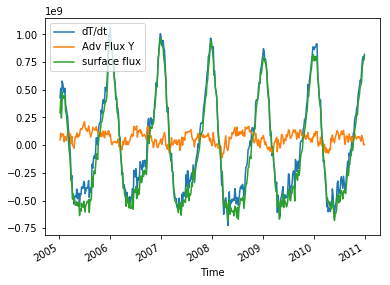

In [115]:
(tottend_south_of_55s / (24*60*60)).plot(label='dT/dt')
(-flux_across_55S).plot(label='Adv Flux Y')
#diff_flux_across_55s.plot()
surface_term.plot(label='surface flux')
plt.legend()

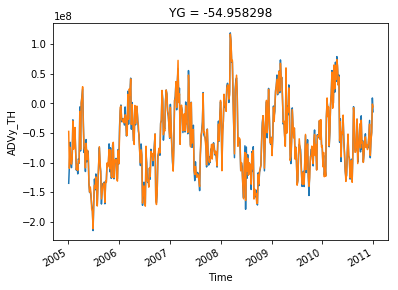

In [117]:
(surface_term - tottend_south_of_55s / (24*60*60)).plot()
flux_across_55S.plot(label='Adv Flux Y')